# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import numpy as np
import speckleret as spr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the interferometric data

(1, 384, 384)
(1, 384, 384)


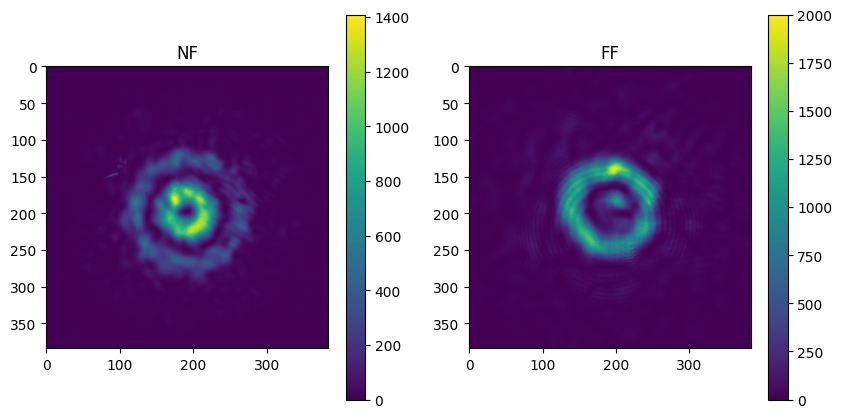

In [88]:
path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\Modes and OAMs\oam'

date = '20250716-172641'
# date = '20250624-171837'
# FF__shaping_frames_

CP = np.load(os.path.join(path, 'NF__shaping_frames_' + date + '.npz'))['frames']
CL = np.load(os.path.join(path, 'FF__shaping_frames_' + date + '.npz'))['frames']

print(CP.shape)
print(CL.shape)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("NF")
plt.imshow(CP[0, ...], vmin=0)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("FF")
plt.imshow(CL[0, ...], vmin=0)
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

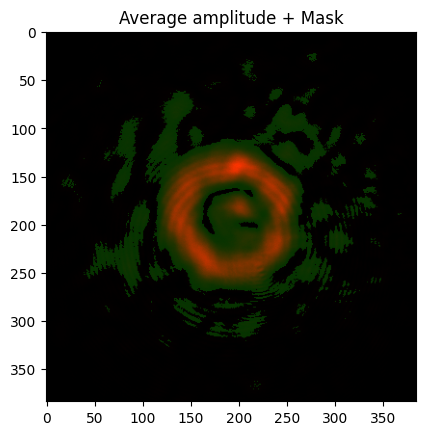

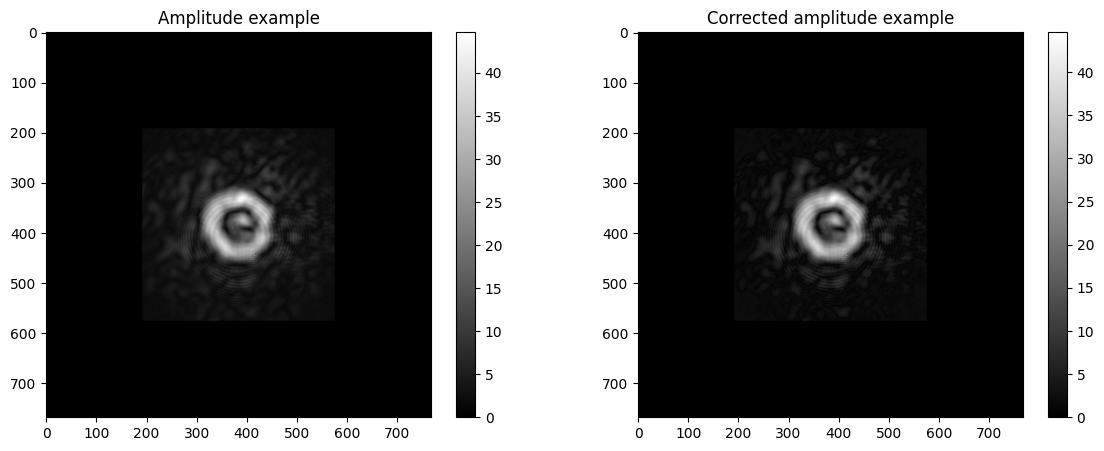

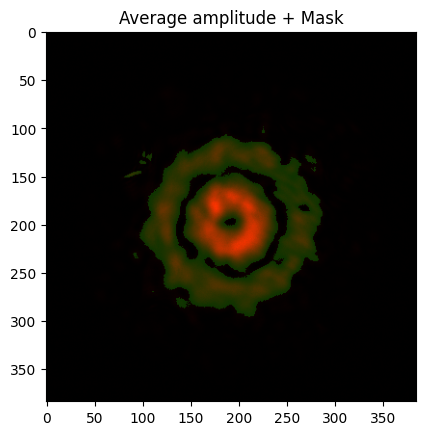

9.96282958984375


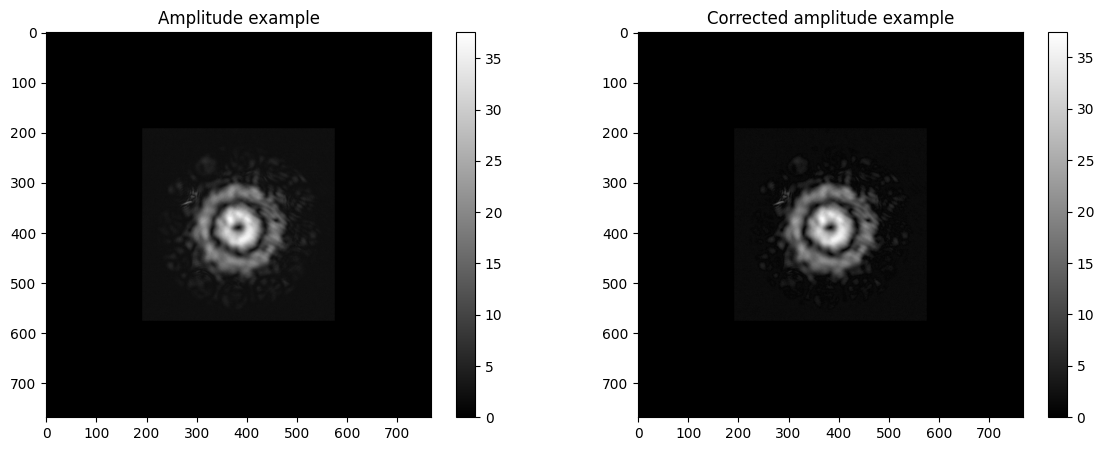

In [89]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.02, plot_result=True, plot_mask=True)
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0,), mask_trsh=0.05, plot_mask=True, plot_result=True)

print(noise_corr)

Let's detect the average centroids

In [90]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(-1, -2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(-1, -2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (np.float64(0.0), np.float64(195.41547441927136))
Average centroid CL: (np.float64(0.0), np.float64(190.15590596251985))


### Data preparation

Select data for phase retrieval

294
(294, 294) 495033.6350316934
(294, 294) 720799.344141492


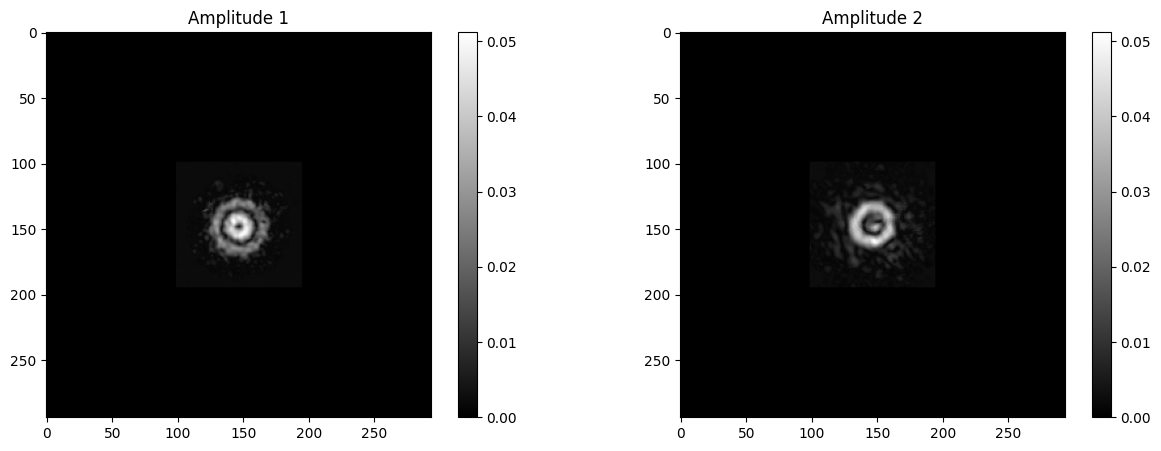

In [91]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 4
bin_cl = 4
N_window = compute_N_win(561.4e-9, 100e-3, bin_cp * 3.45e-6, bin_cl * 3.45e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

# CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
# CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
# ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
ft = np.flip(ft, axis=0)
# ft = np.flip(ft, axis=1)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

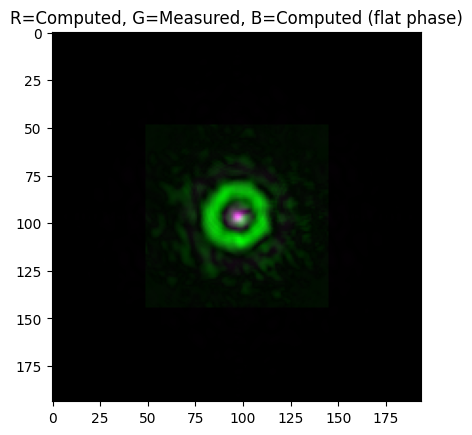

In [92]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 50

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

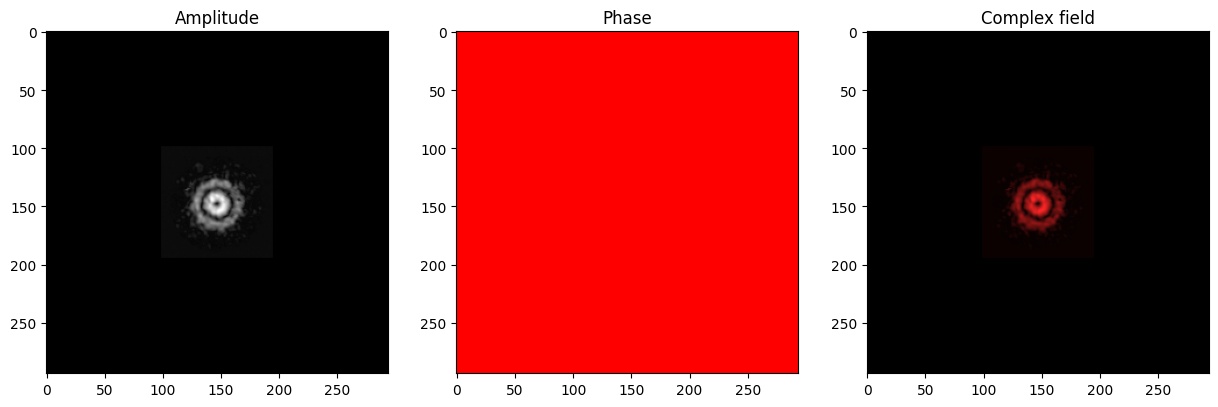

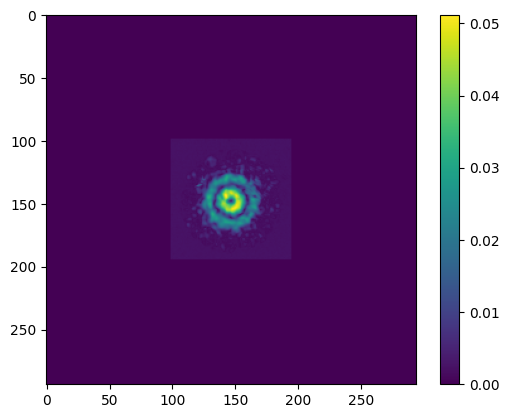

In [93]:
import speckleret.torch as tspr
import torch

tfield = torch.from_numpy(field).to(torch.float)
tfield = tfield.unsqueeze(0).unsqueeze(0)

support = tspr.supports.threshold_support(tfield, threshold=0.00)
# support = spr.supports.disk_support(tfield, radius=48, offsets=(0,0))
supported_field = tspr.transforms.apply_support(tfield, support)
_ = spr.plots.complex_imshow(supported_field.cpu().detach().numpy().squeeze())

plt.figure()
plt.imshow(supported_field.cpu().detach().numpy().squeeze())
plt.colorbar()

In [94]:
from waveoptics.plots.plots import complex_to_hsv


def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = torch.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

Total time: 1.1206 seconds


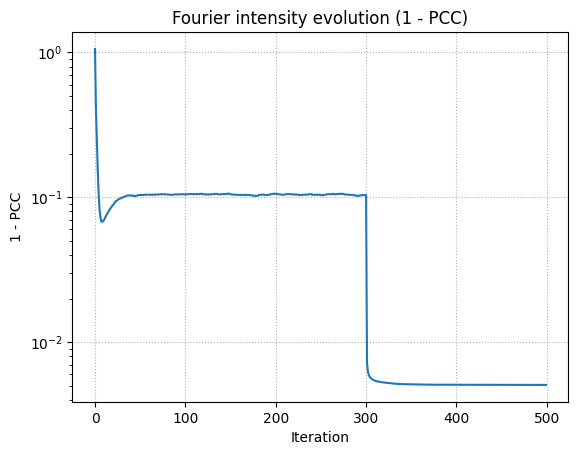

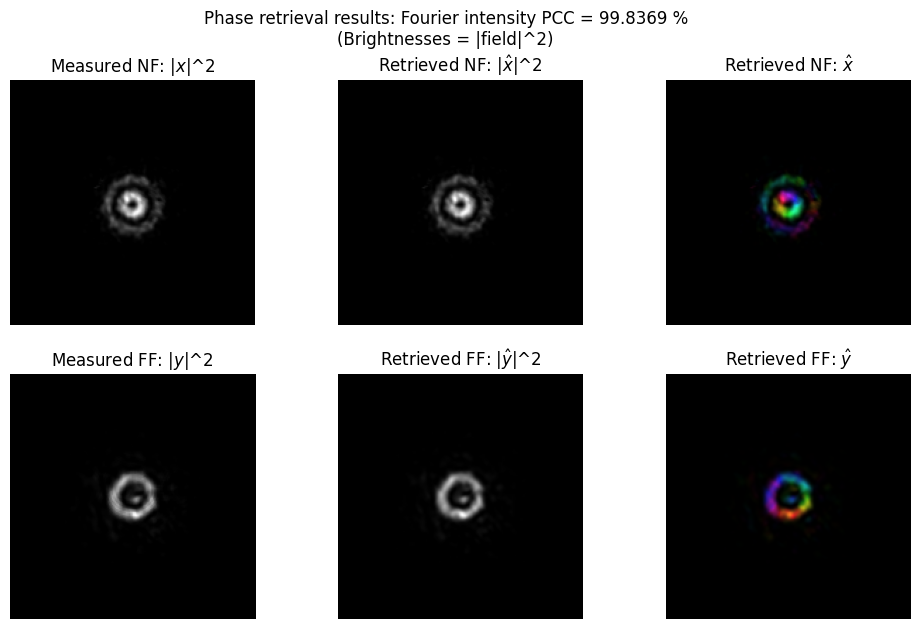

In [95]:
import torch.optim as optim

tft = torch.from_numpy(ft).to(torch.float)
tft = tft.unsqueeze(0).unsqueeze(0)


device = 'cuda'

tfield = tfield.to(device)
tft = tft.to(device)
support = support.to(device)



if device.startswith("cuda"):
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

results = []

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        support=support,
        # init=x,
        # init=tspr.initializers.gradient_descent(
        #         magnitude_near_field=torch.abs(tfield),
        #         magnitude_far_field=torch.abs(tft),
        #         support=support,
        #         optimizer_class=torch.optim.Adam,
        #         optimizer_kwargs=dict(lr=1e-0),
        #         max_iter=50,
        # ),
        # init=tspr.initializers.flat_phases(torch.abs(tfield)),
        init=tspr.initializers.random_phases(torch.abs(tfield)),
        algorithm=tspr.retrieval.RAAR,
        algorithm_kwargs={'beta': 0.90},
        max_iter=300,
)
results.append(result)


x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        support=support,
        init=x,
        # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        # init=tspr.initializers.random_phases(np.abs(tfield)),
        algorithm=tspr.retrieval.ER,
        # algorithm_kwargs={'beta': 0.99},
        max_iter=200,
)
results.append(result)

end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"Total time: {elapsed_time_ms/1000:.4f} seconds")



tspr.retrieval.report_convergence_results(merge_dicts(results), key='pearson_fourier')

x_hat = x
y_hat = tspr.transforms.fourier_transform(x_hat)


hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=2,
    window_crop=60,
)

C:\Users\saucourt\AppData\Local\Temp\ipykernel_15284\2429810730.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
C:\Users\saucourt\AppData\Local\Temp\ipykernel_15284\2429810730.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)


Text(0.5, 1.0, 'Phase retrieval: Fourier field PCC')

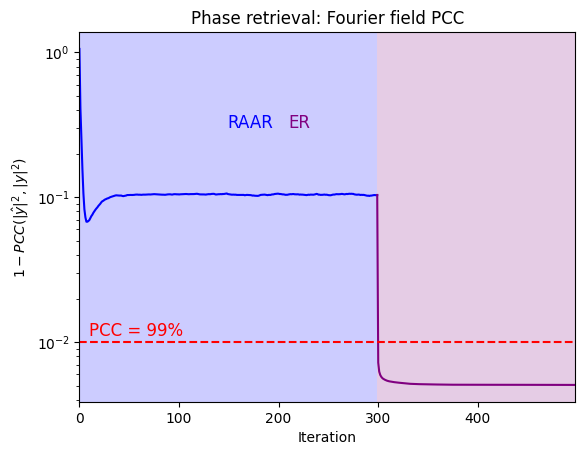

In [96]:

p1 = results[0]['pearson_fourier'].cpu()
t1 = torch.arange(0, len(p1))
p2 = results[1]['pearson_fourier'].cpu()
t2 = torch.arange(len(p1) -1 , len(p1) + len(p2)  -1)

plt.plot(t1, torch.squeeze(p1), label='Algorithm = RAAR', color='blue')
plt.plot(t2, torch.squeeze(p2), label='Algorithm = ER', color='purple')
plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)
plt.axhline(1e-2, color='r', ls='--')
plt.text(10, 1.1e-2, 'PCC = 99%', fontsize=12, color='red')
plt.text(max(t1)//2, 3e-1, 'RAAR', fontsize=12, color='blue')
plt.text(210, 3e-1, 'ER', fontsize=12, color='purple')

plt.xlim([0, len(p1) + len(p2)-2])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$1 - PCC(|\hat{y}|^2, |y|^2)$')
# plt.legend()
plt.title('Phase retrieval: Fourier field PCC')


# np.savez(
#     file=os.path.join(path, 'PR_speckles_' + date + f'_idx={idx}' + '.npz'),
#     field=field, fourier=ft, retrieved_field=x_hat, retrieved_fourier=y_hat, pr_results=results,
# )


# plt.savefig(os.path.join(path, 'figures', 'PR_speckles_dynamic_' + date + f'_idx={idx}' + '.svg'))
# plt.savefig(os.path.join(path, 'figures', 'PR_speckles_dynamic_' + date + f'_idx={idx}' + '.png'))

In [18]:
# np.savez(
#     file=os.path.join(path, 'PR_speckles_' + date + f'_idx={idx}' + '.npz'),
#     field=field, fourier=ft, retrieved_field=x_hat, retrieved_fourier=y_hat, pr_results=results,
# )

## Now let's do new modal decomposition!

In [97]:
import hcmmf

path = r"C:\Users\saucourt\seadrive_root\jeremy s\My Libraries\IALAS\simulation\hollow_core_modes\full structure june 2025"
file = "db_identified_modes.xlsx"

data = hcmmf.build_modal_base_from_database(
    database_path=path,
    database_file=file,
    datafiles_path=os.path.join(path, "field_data_L8407_T12_100_new_out_matlab"),
)
pdata = hcmmf.process_modal_base_from_loaded_database(data, normalize=True)

Loaded file #0: LP01 x 
Loaded file #1: LP01 y 
Loaded file #2: LP02 x 
Loaded file #3: LP02 y 
Loaded file #4: LP03 x 
Loaded file #5: LP03 y 
Loaded file #6: LP04 x
Loaded file #7: LP04 y
Skipped file #8: LP05 x (not identified)
Skipped file #9: LP05 y (not identified)
Loaded file #10: LP11 x a
Loaded file #11: LP11 x b
Loaded file #12: LP11 y a
Loaded file #13: LP11 y b
Loaded file #14: LP12 x a
Loaded file #15: LP12 x b
Loaded file #16: LP12 y a
Loaded file #17: LP12 y b
Loaded file #18: LP13 x a
Loaded file #19: LP13 x b
Skipped file #20: LP13 y a (not identified)
Skipped file #21: LP13 y b (not identified)
Loaded file #22: LP14 x a
Loaded file #23: LP14 x b
Loaded file #24: LP14 y a
Loaded file #25: LP14 y b
Loaded file #26: LP21 x a
Loaded file #27: LP21 x b
Loaded file #28: LP21 y a
Loaded file #29: LP21 y b
Loaded file #30: LP22 x a
Loaded file #31: LP22 x b
Loaded file #32: LP22 y a
Loaded file #33: LP22 y b
Skipped file #34: LP23 x a (not identified)
Loaded file #35: LP23 x 

Text(0.5, 1.0, 'Ey fields')

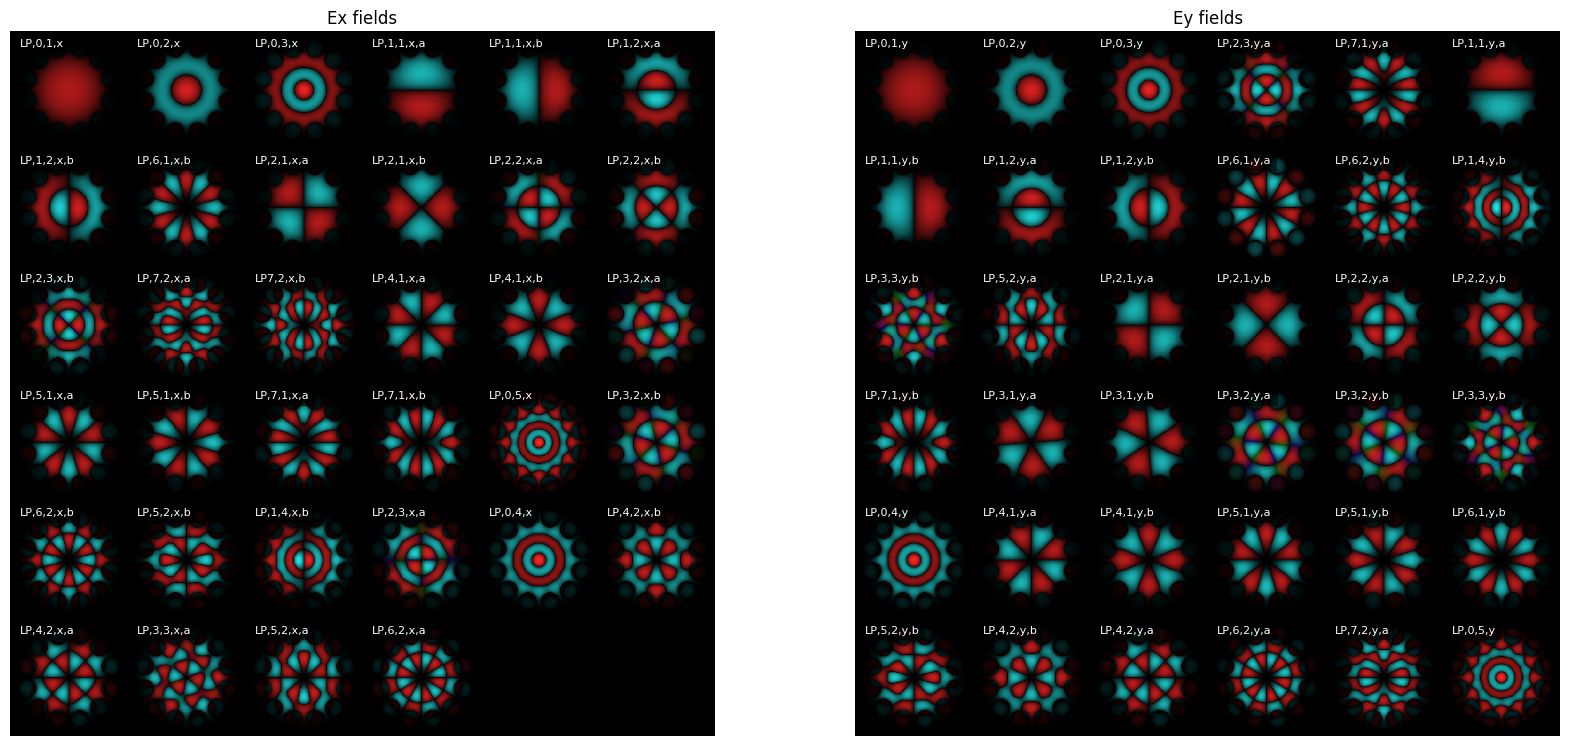

In [98]:
from waveoptics.plots.plots import complex_imshow

ex_fields = np.array([pdata[i]['field_ex'] for i in range(len(pdata)) if pdata[i]['field_ex'] is not None])
ey_fields = np.array([pdata[i]['field_ey'] for i in range(len(pdata)) if pdata[i]['field_ey'] is not None])

tiled_ex_fields, ex_tile_details = hcmmf.utils.tile_matrix(images=ex_fields, complex=True, return_details=True)
tiled_ey_fields, ey_tile_details = hcmmf.utils.tile_matrix(images=ey_fields, complex=True, return_details=True)



plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
hcmmf.plots.imshow_tiled_images_with_labels(
    tiled_images=tiled_ex_fields,
    tile_details=ex_tile_details,
    tile_labels=[pdata[i]['new_name'] for i in range(len(pdata)) if pdata[i]['field_ex'] is not None],
    power=0.5, decimate=4,
)
plt.axis('off')
plt.title('Ex fields')

plt.subplot(1, 2, 2)
hcmmf.plots.imshow_tiled_images_with_labels(
    tiled_images=tiled_ey_fields,
    tile_details=ex_tile_details,
    tile_labels=[pdata[i]['new_name'] for i in range(len(pdata)) if pdata[i]['field_ey'] is not None],
    power=0.5, decimate=4,
)
plt.axis('off')
plt.title('Ey fields')

Text(0.5, 1.0, 'Ey fields')

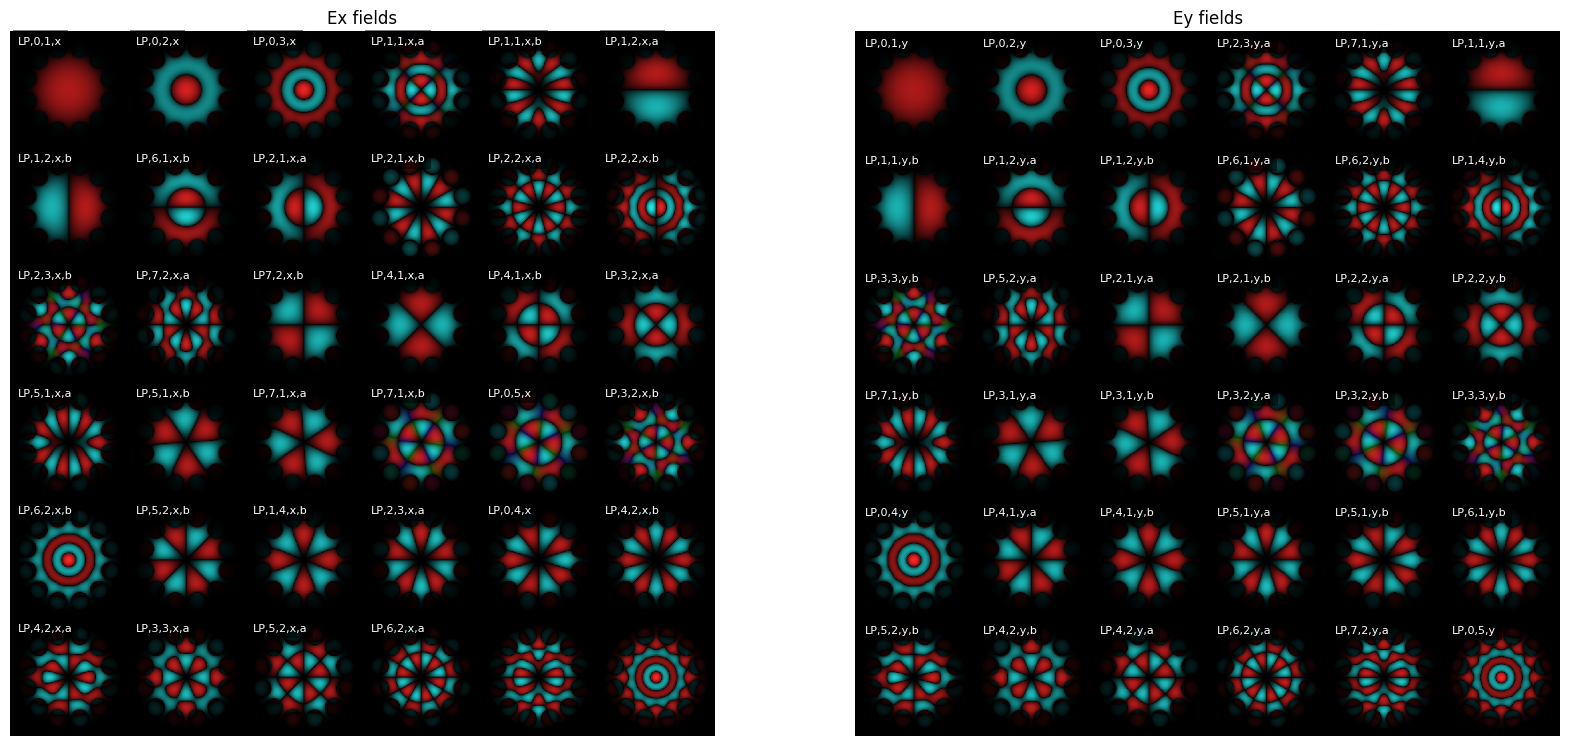

In [99]:
coarse_modes = hcmmf.compose.resample_modes_torch(
    fine_modes=torch.from_numpy(ey_fields).to(torch.cfloat).to('cuda'),
    target_shape=x_hat.shape[2:],
    fine_px_size=1 * 3.45e-6,
    # fine_px_size=156.2e-6 / 195,
    target_px_size=1 * 3.45e-6,
).to('cpu').numpy()

tiled_coarse_fields, coarse_tile_details = hcmmf.utils.tile_matrix(images=coarse_modes, complex=True, return_details=True)



plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
hcmmf.plots.imshow_tiled_images_with_labels(
    tiled_images=tiled_coarse_fields,
    tile_details=coarse_tile_details,
    tile_labels=[pdata[i]['new_name'] for i in range(len(pdata)) if pdata[i]['field_ex'] is not None],
    # tile_labels=None,
    power=0.5, decimate=1,
)
plt.axis('off')
plt.title('Ex fields')

plt.subplot(1, 2, 2)
hcmmf.plots.imshow_tiled_images_with_labels(
    tiled_images=tiled_ey_fields,
    tile_details=ex_tile_details,
    tile_labels=[pdata[i]['new_name'] for i in range(len(pdata)) if pdata[i]['field_ey'] is not None],
    power=0.5, decimate=4,
)
plt.axis('off')
plt.title('Ey fields')

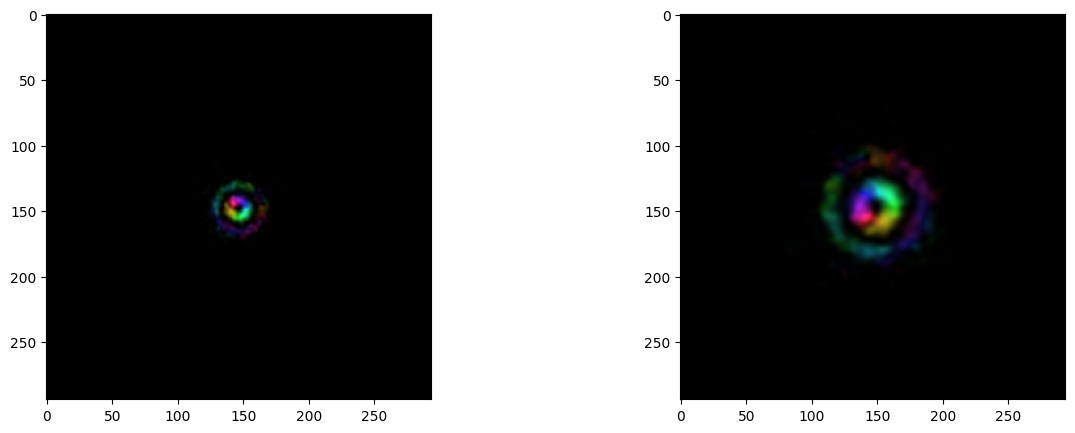

In [100]:
x_new = hcmmf.compose.affine_transform_images(torch.squeeze(x_hat, dim=0), scale=0.5, angle_deg=90, tx=0.0, ty=0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(complex_to_hsv(np.squeeze(x_hat.cpu().numpy()), power=2.0))

plt.subplot(1, 2, 2)
plt.imshow(complex_to_hsv(np.squeeze(x_new.cpu().numpy()), power=2.0))

In [101]:
def normalize_energy(images: torch.Tensor) -> torch.Tensor:
    """
    Normalizes each complex image in the batch to have unit L2 norm.

    Args:
        images: Complex tensor of shape [B, H, W]

    Returns:
        Normalized complex tensor of same shape
    """
    norms = torch.linalg.norm(images.reshape(images.shape[0], -1), dim=1, keepdim=True)  # [B, 1]
    norms = norms.clamp_min(1e-12)  # Avoid divide by zero
    return images / norms.view(-1, 1, 1)


device = 'cuda'
dtype = torch.cdouble


hcmmf_decomposer = hcmmf.compose.BasisDecomposer(basis=torch.from_numpy(coarse_modes).to(dtype).to(device))
x_new = hcmmf.compose.affine_transform_images(torch.squeeze(x_hat, dim=0), scale=0.268, angle_deg=-8.80, tx=0.9, ty=1.89)
x_new = normalize_energy(x_new)
coeffs = hcmmf_decomposer(x_new.to(dtype).to(device), method='pseudo-inverse')


print(f"Total normalized energy: {torch.sum(torch.abs(coeffs) ** 2).item() * 100:.3f}%")

Total normalized energy: 89.383%


In [102]:
import torch
import numpy as np
from scipy.optimize import minimize

def objective(params, x_hat, decomposer, dtype, device):
    scale = float(params[0])
    angle_deg = float(params[1])
    tx_pixels = float(params[2])
    ty_pixels = float(params[3])

    # Apply transform
    x_new = hcmmf.compose.affine_transform_images(
        torch.squeeze(x_hat, dim=0), 
        scale=scale, 
        angle_deg=angle_deg, 
        tx=tx_pixels, 
        ty=ty_pixels
    )
    x_new = normalize_energy(x_new)

    # Compute decomposition
    coeffs = decomposer(x_new.to(dtype).to(device), method='pseudo-inverse')
    
    # Negative total energy (we want to maximize energy)
    total_energy = torch.sum(torch.abs(coeffs) ** 2).item()
    return -total_energy  # minimize negative energy

# Initial guess: scale=1.0, angle=0°, tx=0, ty=0
x0 = [1.0, 0.0, 0.0, 0.0]

# Optimize
result = minimize(
    objective,
    x0,
    args=(x_hat, hcmmf_decomposer, dtype, device),
    method='Powell',  # or 'Powell' or 'L-BFGS-B'
    options={'disp': True, 'maxiter': 200}
)

# Final optimal parameters
opt_scale, opt_angle, opt_tx, opt_ty = result.x
print(f"Optimal: scale={opt_scale:.3f}, angle={opt_angle:.2f}°, tx={opt_tx:.2f} px, ty={opt_ty:.2f} px")

Optimization terminated successfully.
         Current function value: -0.895016
         Iterations: 3
         Function evaluations: 158
Optimal: scale=0.265, angle=-8.45°, tx=0.87 px, ty=1.97 px


In [103]:
device = 'cuda'
dtype = torch.cdouble


hcmmf_decomposer = hcmmf.compose.BasisDecomposer(basis=torch.from_numpy(coarse_modes).to(dtype).to(device))
x_new = hcmmf.compose.affine_transform_images(torch.squeeze(x_hat, dim=0), scale=np.float32(opt_scale), angle_deg=np.float32(opt_angle), tx=np.float32(opt_tx), ty=np.float32(opt_ty))
# x_new = hcmmf.compose.affine_transform_images(torch.squeeze(x_hat, dim=0), scale=0.268, angle_deg=-8.80, tx=0.9, ty=1.89)

x_new = normalize_energy(x_new)
coeffs = hcmmf_decomposer(x_new.to(dtype).to(device), method='direct')

print(f"Total normalized energy: {torch.sum(torch.abs(coeffs) ** 2).item() * 100:.3f}%")

Total normalized energy: 89.377%


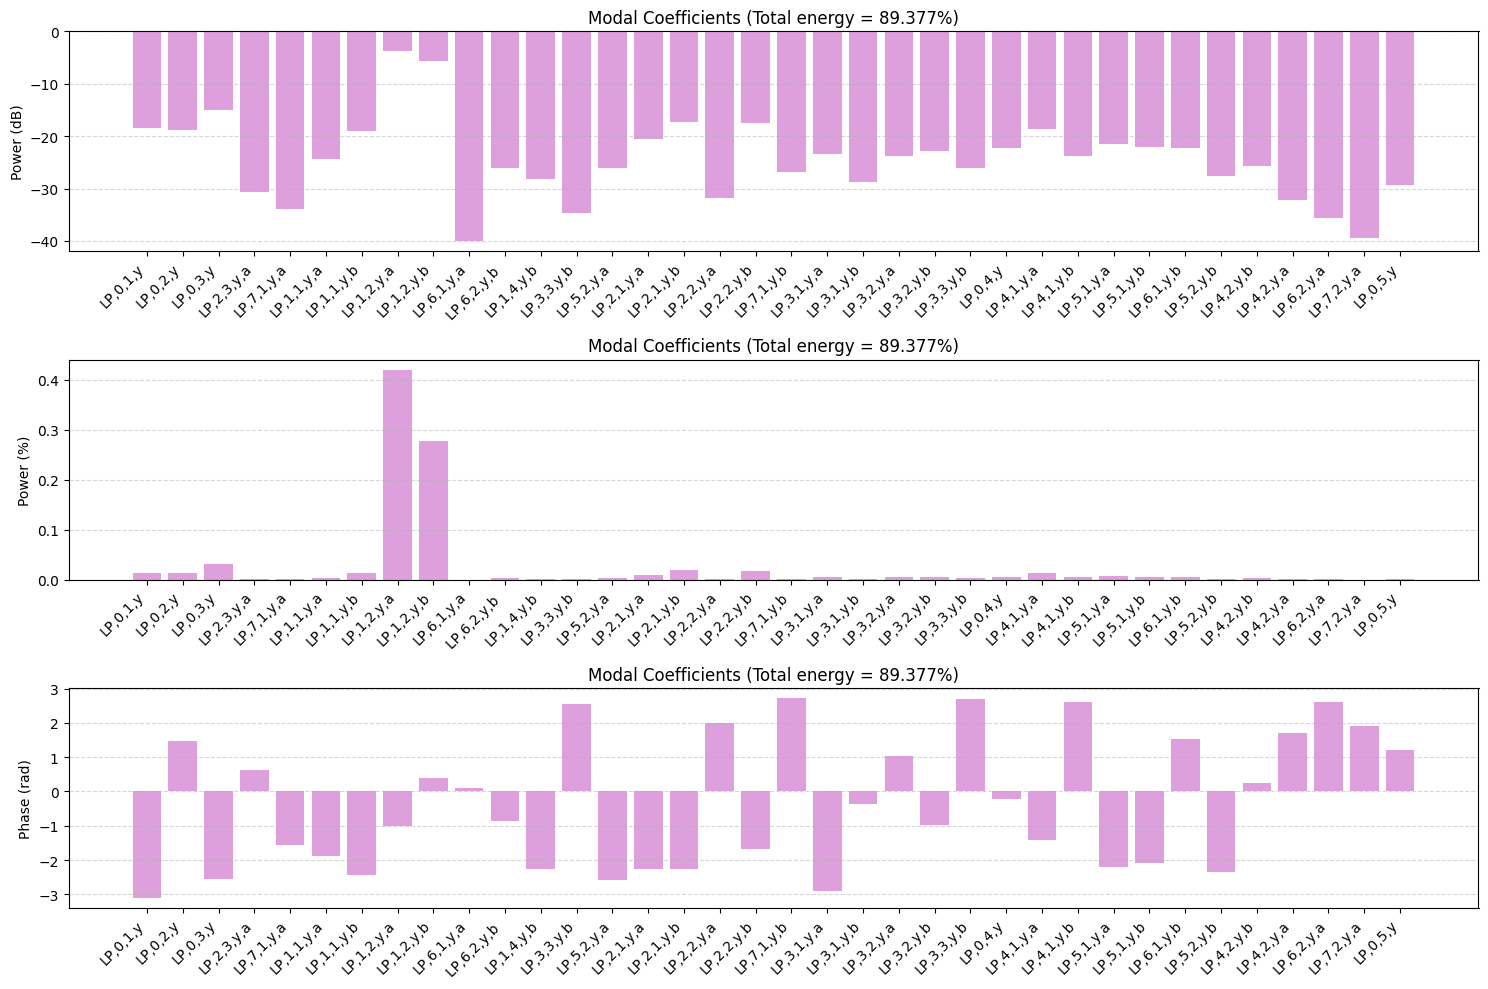

In [104]:
num_coeffs = coeffs.shape[1]
coeffs_abs_db = 10 * torch.log10(torch.abs(coeffs.cpu()) ** 2 + 1e-12) # Avoid log(0)
coeffs_abs_db = coeffs_abs_db.cpu().numpy()
labels = [pdata[i]['new_name'] for i in range(len(pdata)) if pdata[i]['field_ey'] is not None]

# Plot
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)

plt.bar(np.arange(num_coeffs), coeffs_abs_db.flatten(), color='plum')
plt.xticks(ticks=np.arange(num_coeffs), labels=labels, rotation=45, ha='right')
plt.ylabel("Power (dB)")
plt.title(f"Modal Coefficients (Total energy = {torch.sum(torch.abs(coeffs) ** 2).item() * 100:.3f}%)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.subplot(3, 1, 2)
plt.bar(np.arange(num_coeffs), (torch.abs(coeffs.cpu()) ** 2).cpu().numpy().flatten(), color='plum')
plt.xticks(ticks=np.arange(num_coeffs), labels=labels, rotation=45, ha='right')
plt.ylabel("Power (%)")
plt.title(f"Modal Coefficients (Total energy = {torch.sum(torch.abs(coeffs) ** 2).item() * 100:.3f}%)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.subplot(3, 1, 3)
plt.bar(np.arange(num_coeffs), (torch.angle(coeffs.cpu())).cpu().numpy().flatten(), color='plum')
plt.xticks(ticks=np.arange(num_coeffs), labels=labels, rotation=45, ha='right')
plt.ylabel("Phase (rad)")
plt.title(f"Modal Coefficients (Total energy = {torch.sum(torch.abs(coeffs) ** 2).item() * 100:.3f}%)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()


In [111]:
labels = [pdata[i]['new_name'] for i in range(len(pdata)) if pdata[i]['field_ey'] is not None]

lp_coeffs_dict = {}

for i, label in enumerate(labels):
    split_label = label.split(',')  
    
    n = int(split_label[1])
    m = int(split_label[2])
    
    
    if len(split_label) > 4:
        orientation = split_label[4]
        
    key = (n, m)
    
    if key not in lp_coeffs_dict:
        lp_coeffs_dict[key] = []
        
    lp_coeffs_dict[key].append(coeffs[0, i].item())

C:\Users\saucourt\AppData\Local\Temp\ipykernel_15284\885335041.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  tri1 = patches.Polygon([[x, y], [x+1, y], [x, y+1]], color=color1, edgecolor='none')
C:\Users\saucourt\AppData\Local\Temp\ipykernel_15284\885335041.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  tri2 = patches.Polygon([[x+1, y], [x+1, y+1], [x, y+1]], color=color2, edgecolor='none')


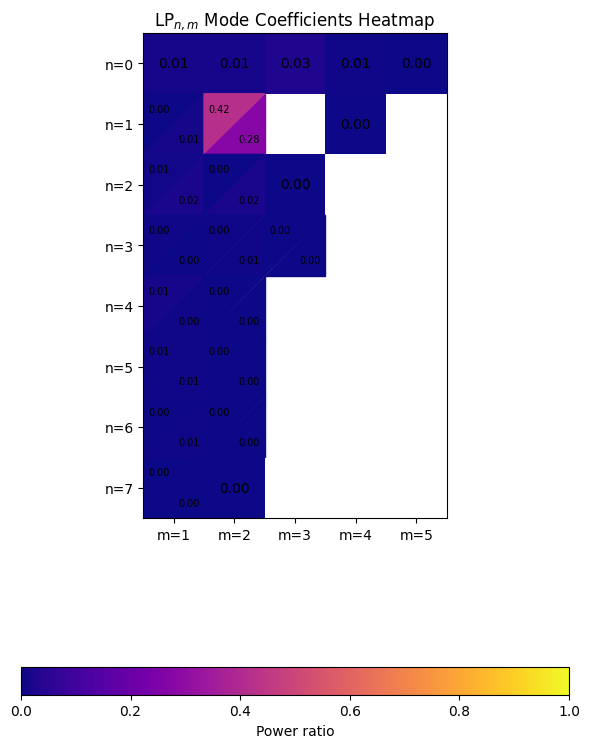

In [109]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Example LPnm coefficient map:
# - rows = n (radial index)
# - cols = m (azimuthal index)
# - each entry is [val] or [val1, val2] for degenerate orientations
# lp_coeffs = {
#     (0, 1): [0.85],
#     (1, 1): [0.45, 0.55],
#     (2, 1): [0.20, 0.35],
#     (1, 2): [0.10],
#     (2, 2): [0.05, 0.15],
#     (3, 3): [0.25],
# }
lp_coeffs = lp_coeffs_dict

n_max = max(k[0] for k in lp_coeffs.keys())
m_max = max(k[1] for k in lp_coeffs.keys())

fig, ax = plt.subplots(figsize=(m_max+1, n_max+1))

for (n, m), values in lp_coeffs.items():
    x, y = m, n  # Column = m, Row = n

    if len(values) == 1:
        val = np.abs(values[0]) ** 2
        color = plt.cm.plasma(val)
        ax.add_patch(patches.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='none'))
        ax.text(x + 0.5, y + 0.5, f"{val:.2f}", ha='center', va='center', color='white' if val > 0.5 else 'black')
    else:
        val1, val2 = values
        val1 = np.abs(val1) ** 2
        val2 = np.abs(val2) ** 2
        color1 = plt.cm.plasma(val1)
        color2 = plt.cm.plasma(val2)

        # Bottom-left triangle
        tri1 = patches.Polygon([[x, y], [x+1, y], [x, y+1]], color=color1, edgecolor='none')
        ax.add_patch(tri1)
        ax.text(x + 0.25, y + 0.25, f"{val1:.2f}", ha='center', va='center', fontsize=7, color='white' if val1 > 0.5 else 'black')

        # Top-right triangle
        tri2 = patches.Polygon([[x+1, y], [x+1, y+1], [x, y+1]], color=color2, edgecolor='none')
        ax.add_patch(tri2)
        ax.text(x + 0.75, y + 0.75, f"{val2:.2f}", ha='center', va='center', fontsize=7, color='white' if val2 > 0.5 else 'black')

# Axes settings
ax.set_xlim(1, m_max + 1)
ax.set_ylim(0, n_max + 1)
ax.set_xticks(np.arange(1, m_max + 1) + 0.5)
ax.set_yticks(np.arange(n_max + 1) + 0.5)
ax.set_xticklabels([f"m={i}" for i in range(1, m_max + 1)])
ax.set_yticklabels([f"n={i}" for i in range(n_max + 1)])
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_title("LP$_{n,m}$ Mode Coefficients Heatmap")
# plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

# Colorbar
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap='plasma', norm=plt.Normalize(0, 1))
cbar = plt.colorbar(sm, ax=ax, pad=0.2, orientation='horizontal')
cbar.set_label("Power ratio")

plt.tight_layout()
plt.show()


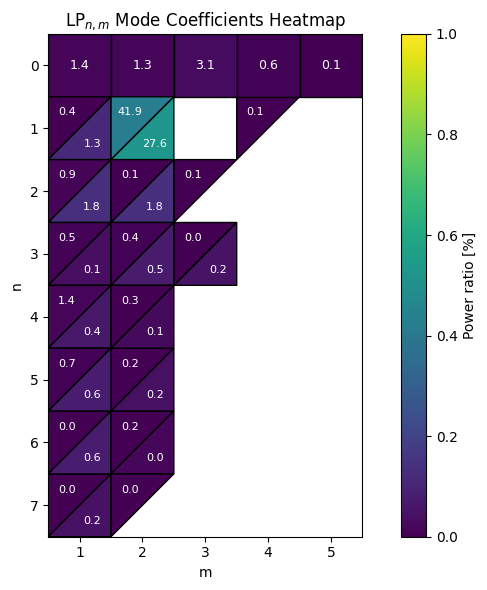

In [135]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np


max_n = max(k[0] for k in lp_coeffs_dict.keys())
max_m = max(k[1] for k in lp_coeffs_dict.keys())

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')

for (n, m), values in lp_coeffs_dict.items():
    i = max_n - n  # vertical index (invert for top-down)
    j = m          # horizontal index

    if len(values) == 1:
        if n > 0:
            # Triangle top-left
            tri1 = Polygon([[j, i+1], [j, i], [j+1, i+1]], closed=True, color=plt.cm.viridis(np.abs(values[0]) ** 2), ec='black')
            ax.add_patch(tri1)
            ax.text(j + 0.3, i + 0.75, f"{np.abs(values[0]) ** 2 * 100:.1f}", ha='center', va='center', fontsize=8, color='white')
        else:
            # Full square
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=plt.cm.viridis(np.abs(values[0]) ** 2), ec='black'))
            ax.text(j + 0.5, i + 0.5, f"{np.abs(values[0]) ** 2 * 100:.1f}", ha='center', va='center', fontsize=9, color='white')
    elif len(values) == 2:
        # Triangle top-left
        tri1 = Polygon([[j, i+1], [j, i], [j+1, i+1]], closed=True, color=plt.cm.viridis(np.abs(values[0]) ** 2), ec='black')
        ax.add_patch(tri1)
        ax.text(j + 0.3, i + 0.75, f"{np.abs(values[0]) ** 2 * 100:.1f}", ha='center', va='center', fontsize=8, color='white')

        # Triangle bottom-right
        tri2 = Polygon([[j+1, i], [j, i], [j+1, i+1]], closed=True, color=plt.cm.viridis(np.abs(values[1]) ** 1), ec='black')
        ax.add_patch(tri2)
        ax.text(j + 0.7, i + 0.25, f"{np.abs(values[1]) ** 2 * 100:.1f}", ha='center', va='center', fontsize=8, color='white')

# Axis labeling
ax.set_xlim(1, m_max + 1)
ax.set_ylim(0, n_max + 1)
ax.set_xticks(np.arange(1, m_max + 1) + 0.5)
ax.set_yticks(np.arange(n_max + 1) + 0.5)
ax.set_xticklabels(np.arange(1, m_max + 1))
ax.set_yticklabels(reversed(np.arange(n_max + 1)))
ax.set_xlabel('m')
ax.set_ylabel('n')
ax.grid(False)
ax.set_title("LP$_{n,m}$ Mode Coefficients Heatmap")

from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap='viridis', norm=plt.Normalize(0, 1))
cbar = plt.colorbar(sm, ax=ax, pad=0.05, orientation='vertical')
cbar.set_label("Power ratio [%]")

plt.tight_layout()
plt.show()